In [1]:
import warnings
warnings.filterwarnings(action='ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.datasets import load_iris
import pandas_profiling as pp

dataset = load_iris()

In [2]:
# dataset.keys()
# dataset.data[:5]
# dataset.target
# dataset.target_names
# dataset.feature_names
print(dataset.frame)

None


In [3]:
cols = ['sepal_length','sepal_width', 'petal_length', 'petal_width']
df = pd.DataFrame(data=dataset.data, columns=cols)
df['target'] = dataset.target
df.info()

#df.to_csv('iris.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   target        150 non-null    int32  
dtypes: float64(4), int32(1)
memory usage: 5.4 KB


In [4]:
#import sweetviz as sv
# import pandas_profiling as pp
# from sklearn.model_selection import train_test_split

# import pandas as pd
# df = pd.read_csv("diabetes.csv")
# train_X, test_X = train_test_split(df, test_size=0.2, random_state=100, shuffle=True)
#-------------------------------------------
# sv_report = sv.compare([train_X, 'Train'], [test_X, 'Test'], 'Outcome')
# sv_report.show_html('eda/sv_report.html')
#-------------------------------------------
# df.profile_report()
# pr_report=df.profile_report()
# pr_report.to_file('pr_report.html')
#-------------------------------------------


In [5]:
df_y = df.iloc[:,-1]
df_X = df.iloc[:,:-1]
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.2, random_state=100, shuffle=True)
y_test.unique()

array([2, 0, 1])

## 다중분류용 함수

In [6]:
def myscore(y_test, pred, proba, pr_curve=0, auc_curve=0):
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred, average='macro')
    recall = recall_score(y_test, pred, average='macro')
    f1 = f1_score(y_test, pred, average='macro')
    auc = roc_auc_score(y_test, proba, average='macro', multi_class='ovr')
    print(f'Accuracy:{accuracy:.6f}, Precision:{precision:.6f}, Recall:{recall:.6f}, F1:{f1:.6f}, AUC:{auc:.6f}')
    mtx = confusion_matrix(y_test, pred)
    print(mtx)

In [7]:
dt = DecisionTreeClassifier(random_state=100)
dt.fit(X_train, y_train)
pred = dt.predict(X_test)
proba = dt.predict_proba(X_test)
print(pred[:5], proba[:5])
myscore(y_test, pred, proba)

[2 0 2 0 2] [[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]
Accuracy:0.966667, Precision:0.976190, Recall:0.944444, F1:0.957351, AUC:0.962418
[[11  0  0]
 [ 0  5  1]
 [ 0  0 13]]


In [8]:
from sklearn.metrics import classification_report
report = classification_report(y_test, pred)
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      0.83      0.91         6
           2       0.93      1.00      0.96        13

    accuracy                           0.97        30
   macro avg       0.98      0.94      0.96        30
weighted avg       0.97      0.97      0.97        30



(30, 5)


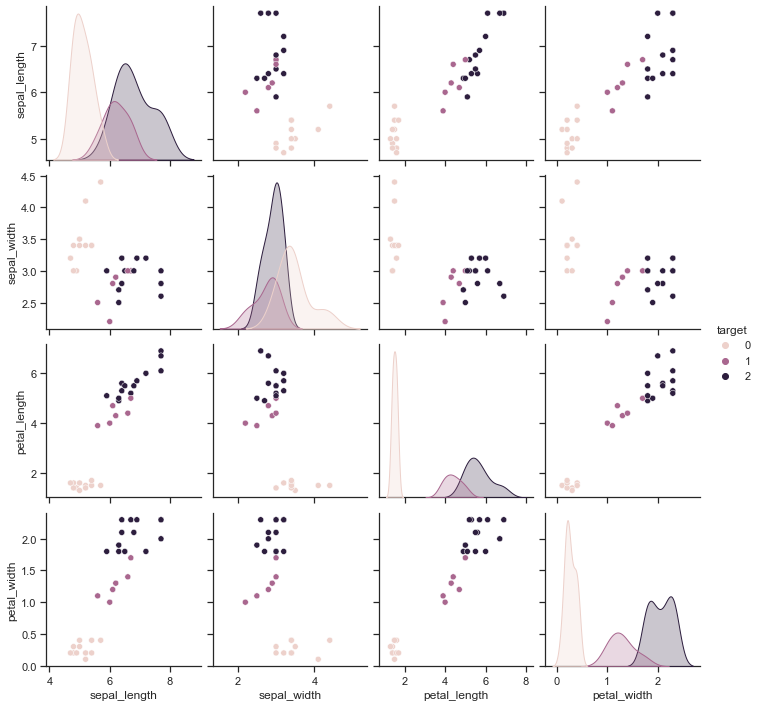

In [9]:
temp_test_df = X_test.copy()
temp_test_df["target"] = y_test
print(temp_test_df.shape)

sns.set_theme(style="ticks")
sns.pairplot(temp_test_df, hue="target")
plt.show()

Index(['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'target'], dtype='object')


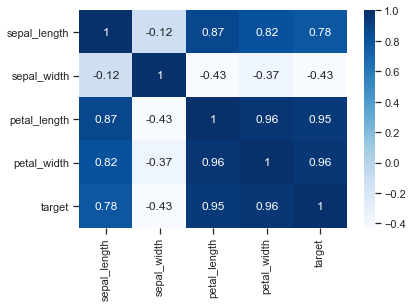

In [10]:
#------------ 결측X, 수치형 : 분석데이터
#분석 -------- 상관분석 : 피쳐관계
#---------------------: 일반피쳐:다중공선 타켓피쳐:상관도
print(df.columns)
sns.heatmap(df.corr(), annot=True, cmap='Blues')
plt.show()

### Pipeline = Scaler + PCA

In [48]:
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
# X_train_scaler = std_scaler.fit_transform(X_train)   # 각각 스케일링
# X_test_scaler  = std_scaler.transform(X_test)
pca = PCA(n_components=2)
# res = pca.transform(X_test)

pipeline = make_pipeline(std_scaler, pca) #파이프라인 = 스케일링, PCA 한번에
pca_res = pipeline.fit_transform(df_X)
print(pca_res.shape)
print('주성분(PC) 2개가 전체 데이터를 얼마나 설명할 수 있는가?\n', np.sum(pca.explained_variance_ratio_), pca.explained_variance_ratio_)

(150, 2)
주성분(PC) 2개가 전체 데이터를 얼마나 설명할 수 있는가?
 0.9581320720000164 [0.72962445 0.22850762]


In [50]:
pca_df = pd.DataFrame(data=pca_res, columns=['pca1', 'pca2'])
pca_df['target'] = df_y

In [51]:
pca_df_y = pca_df.iloc[:,-1]
pca_df_X = pca_df.iloc[:,:-1]
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(pca_df_X, pca_df_y, test_size=0.2, random_state=100, shuffle=True)
dt = DecisionTreeClassifier(random_state=100)
dt.fit(X_train_pca, y_train_pca)
pred = dt.predict(X_test_pca)
proba = dt.predict_proba(X_test_pca)
print(pred[:5], proba[:5])
myscore(y_test_pca, pred, proba)

[2 0 2 0 2] [[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]
Accuracy:0.966667, Precision:0.976190, Recall:0.944444, F1:0.957351, AUC:0.962418
[[11  0  0]
 [ 0  5  1]
 [ 0  0 13]]


### K-Fold

In [14]:
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score, GridSearchCV
n_split_num = 5
scores = []
#kfold = KFold(n_splits=n_split_num, shuffle=False)
kfold = KFold(n_splits=n_split_num, shuffle=True, random_state=30)
for train_index, test_index in kfold.split(df):
    print('Train:', len(train_index), 'Test:', len(test_index))
    X_train, X_test = df.iloc[train_index, :-1], df.iloc[test_index, :-1]
    y_train, y_test = df.iloc[train_index, -1], df.iloc[test_index, -1]
    dt.fit(X_train, y_train)
    pred = dt.predict(X_test)
    #df_score = accuracy_score(y_test, pred)
    df_score = f1_score(y_test, pred, average='macro')
    scores.append(df_score)
    #print('Accuracy: ', round(df_score, 6))
    print('F1: ', round(df_score, 6))
    
print('{:d}회 평균 F1:{:.4f}'.format(n_split_num, np.array(scores).mean()))

Train: 120 Test: 30
F1:  0.925926
Train: 120 Test: 30
F1:  0.974013
Train: 120 Test: 30
F1:  0.92963
Train: 120 Test: 30
F1:  1.0
Train: 120 Test: 30
F1:  0.92963
5회 평균 F1:0.9518


### StratifiedKFold

In [26]:
n_split_num = 5
scores = []
skfold = StratifiedKFold(n_splits=n_split_num, shuffle=True, random_state=100)
for train_index, test_index in skfold.split(df_X, df_y): # -> StratifiedKFold는 고르게 분포
    print('Train:', len(train_index), 'Test:', len(test_index))
    X_train, X_test = df_X.iloc[train_index], df_X.iloc[test_index]
    y_train, y_test = df_y.iloc[train_index], df_y.iloc[test_index]
    dt.fit(X_train, y_train)
    pred = dt.predict(X_test)
    #df_score = accuracy_score(y_test, pred)
    df_score = f1_score(y_test, pred, average='macro')
    scores.append(df_score)
    #print('Accuracy: ', round(df_score, 6))
    print('F1: ', round(df_score, 6))
    
print('{:d}회 평균 F1:{:.4f}'.format(n_split_num, np.array(scores).mean()))

Train: 120 Test: 30
F1:  1.0
Train: 120 Test: 30
F1:  0.93266
Train: 120 Test: 30
F1:  0.93266
Train: 120 Test: 30
F1:  0.966583
Train: 120 Test: 30
F1:  0.966583
5회 평균 F1:0.9597


### cross_val_score
내부적 cv(폴드)는 StratifiedKFold 전략을 따른다.<br>
각 폴드마다 taget의 값들이 편중되지않게 들어가게 한다

In [35]:
dt = DecisionTreeClassifier(random_state=100)
rf = RandomForestClassifier()
lr = LogisticRegression()
knn = KNeighborsClassifier()

scores_list = cross_val_score(dt, df_X, df_y, cv=skfold, #CV값 숫자 = 반복횟수 -> Fold방식 결정
               scoring = "f1_macro", verbose=0)
scores_list.mean()

0.9530472646262119

In [36]:
scores_list = cross_val_score(dt, df_X, df_y, cv=kfold, #CV값 숫자 = 반복횟수 -> Fold방식 결정
               scoring = "f1_macro", verbose=0)
scores_list.mean()

0.9518396357376867

## GridSerchCV

In [44]:
#cross_val_score +  param_grid(튜닝) / refit=True(best모델반영)
myparam = {'max_depth':[1,3,5,7], 'min_samples_split':[1,2,3]}
GCV_model = GridSearchCV(dt, param_grid=myparam, refit=True, cv=5, scoring='f1_macro',verbose=0)
GCV_model.fit(X_train, y_train)

#max_depth 4번 * min_samples_split 3번 * cv=5  = 총 60번 학습
print(GCV_model.best_score_)
print(GCV_model.best_estimator_)
print(GCV_model.best_params_)

pred = GCV_model.predict(X_test) # <-- CSV파일 넣고 돌리기
df_score = f1_score(y_test,pred, average='macro')
print("F1 : {:.6f}".format(df_score))

0.9579707438530969
DecisionTreeClassifier(max_depth=3, random_state=100)
{'max_depth': 3, 'min_samples_split': 2}
F1 : 1.000000
